In [1]:
from Hyperparametertuning.src.Embedder import Embedder
from Hyperparametertuning.src.LLMTuner import LLM_Hyperparamter_tuner
from Hyperparametertuning.src.util import plot_losses
from Hyperparametertuning.src.RandomSeachTuner import RandomSearch_Tuner

import json
from flaml import AutoML
from sklearn.datasets import fetch_20newsgroups
import pickle
import numpy as np
import matplotlib.pyplot as plt





/Users/pwag/Documents/Projekte/Intern/hyperparameter_tuning_with_llms/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embedder_name = "distiluse-base-multilingual-cased-v2"

## Embedd the data

In [3]:
train = fetch_20newsgroups(subset='train', shuffle=True)
test = fetch_20newsgroups(subset='test', shuffle=True)


In [16]:

embedder = Embedder(embedder_name)

train['embedding'] = embedder.embedd(train.data)
test['embedding'] = embedder.embedd(test.data)

with open("./TextClassification/data/train_"+embedder_name+".pkl", "wb") as pickle_file:
    pickle.dump(dict(train), pickle_file)

with open("./TextClassification/data/test_"+embedder_name+".pkl", "wb") as pickle_file:
    pickle.dump(dict(test), pickle_file)


## Read the embedded data

In [3]:
with open("./Hyperparametertuning/data/train_"+embedder_name+".pkl", "rb") as pickle_file:
    train = pickle.load(pickle_file)

with open("./Hyperparametertuning/data/test_"+embedder_name+".pkl", "rb") as pickle_file:
    test = pickle.load(pickle_file)

#train, test = subsample(train, test, 0.1)

## Analyse the dataset

In [6]:
for i,target in enumerate(train['target_names']):
    print(f"Topic: {target}")
    print([j for j,k in zip(train['data'], train['target']) if k == i][3])
    print("--------")

Topic: alt.atheism
From: chrisb@seachg.com (Chris Blask)
Subject: Re: islamic authority over women
Reply-To: chrisb@seachg.com (Chris Blask)
Organization: Me, Mississauga, Ontario, Canada
Lines: 78

snm6394@ultb.isc.rit.edu (S.N. Mozumder ) writes:
>In article <1993Apr7.163445.1203@wam.umd.edu> west@next02.wam.umd.edu writes:
>>> >> And belief causes far more horrors.
>>> >> Crusades, 
>>> >> the emasculation and internment of Native Americans,  
>>> >> the killing of various tribes in South America.
>>> >-the Inquisition
>>> >-the Counter-reformation and the wars that followed
>>> >-the Salem witch trials
>>> >-the European witch hunts
>>> >-the holy wars of the middle east
>>> >-the colonization/destruction of Africa
>>> >-the wars between Christianity and Islam (post crusade)
>>> >-the genocide (biblical) of the Canaanites and Philistines
>>> >-Aryian invasion of India
>>> >-the attempted genocide of Jews by Nazi Germany
>>> >-the current missionary assaults on tribes in Africa
>>> 

/var/folders/dg/8n0xxn4d09b0l8s58qy23x5snx2m3q/T/ipykernel_11110/3154349571.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(train['target_names'], rotation=45, ha='right', size=14);


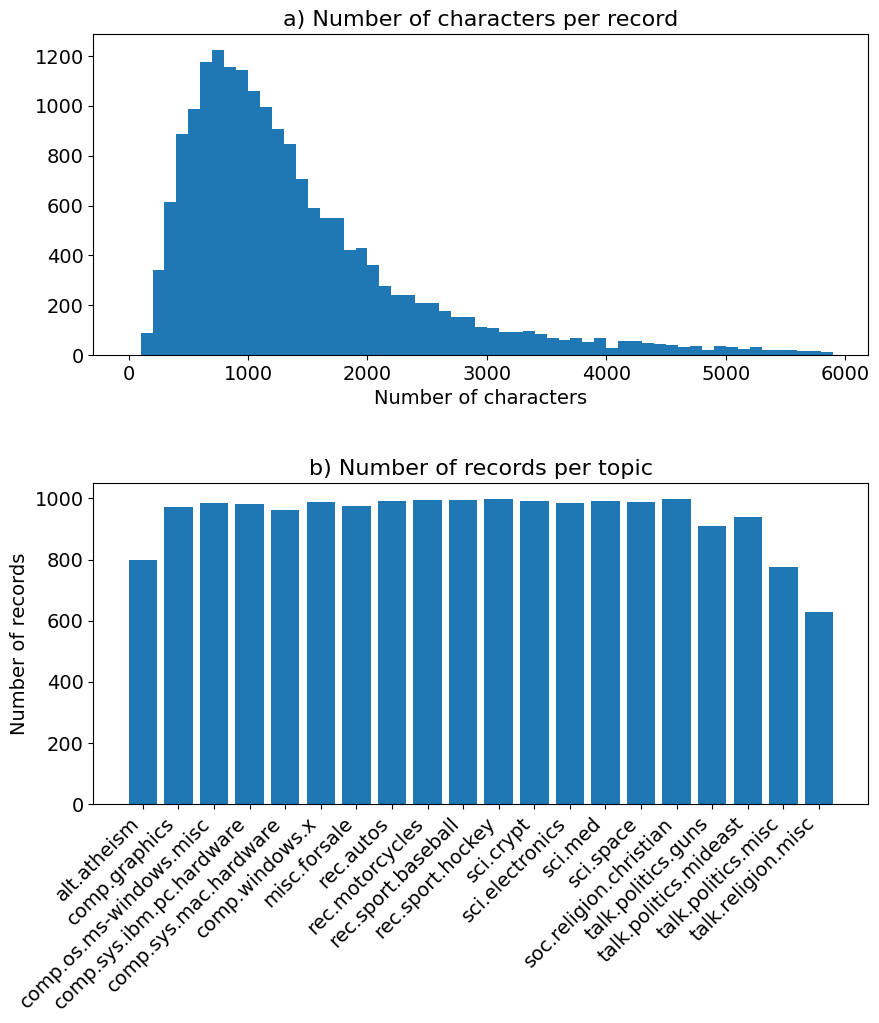

In [5]:
fout="/Users/pwag/OneDrive - PPI AG/Dokumente/Artikel/Hyperparameter tuning with LLMs/Bilder/figure1.png"

d = train['data'] + test['data']
t = np.concatenate((train['target'], test['target']))
n_classes = []
for i,target in enumerate(train['target_names']):
    n_classes.append(len([j for j,k in zip(d, t) if k == i]))
n_character = [len(i) for i in d]


fig, ax = plt.subplots(2,1, figsize=(10, 10))
ax[1].bar(train['target_names'], n_classes)
# historgram of n_character
ax[0].hist(n_character, bins=range(0,6000,100), color="C0")
# rotate x labels
ax[1].set_xticklabels(train['target_names'], rotation=45, ha='right', size=14);
ax[1].set_title("b) Number of records per topic", size=16)
ax[1].set_ylabel('Number of records', size=14)
ax[1].set_ylabel('Number of records', size=14)
ax[0].set_xlabel('Number of characters', size=14)
ax[0].set_title('a) Number of characters per record', size=16)
# set fontsize of xticklabel to 14
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
# increase space between subplots
fig.subplots_adjust(hspace=0.4)

fig.savefig(fout)


In [27]:
print ("Number of characters")
print(f"Minimum: {min(n_character)}")
print(f"Maximum: {max(n_character)}")
print(f"Median: {np.median(n_character)}")

print("Train-Test split")
print(f"Train-Test ratio: {len(train['data']) / (len(train['data']) + len(test['data']))}")
print(f"Train: {len(train['data'])}")
print(f"Test: {len(test['data'])}")

Number of characters
Minimum: 115
Maximum: 160616
Median: 1175.0
Train-Test split
Train-Test ratio: 0.6003395946089356
Train: 11314
Test: 7532


## SVM

### Use LLM for hyperparamter tuning

In [4]:
classifier_type = "svc"
n_iter = 10
#fout = f"./Hyperparametertuning/data/{classifier_type}_losses_llm_search_s100_it{n_iter}.json"
fout = "./Hyperparametertuning/data/test.json"

LLM_Tuner = LLM_Hyperparamter_tuner(classifier_type=classifier_type, train=train, test=test)
LLM_Tuner.run_optimization(iterations=n_iter, fout=fout)

Initial config
{'C': 0.001, 'kernel': 'poly'}
Initial loss: 0.9470260223048327
-------------
Iteration: 1
config: {'C': 1, 'kernel': 'rbf'}
loss: 0.21216144450345198
-------------
Iteration: 2
config: {'C': 10, 'kernel': 'sigmoid'}
loss: 0.28000531067445567
-------------
Iteration: 3
config: {'C': 100, 'kernel': 'rbf'}
loss: 0.2075146043547531
-------------
Iteration: 4
config: {'C': 0.1, 'kernel': 'rbf'}
loss: 0.26274561869357405
-------------
Iteration: 5
config: {'C': 50, 'kernel': 'rbf'}
loss: 0.2072490706319703
-------------
Iteration: 6
config: {'C': 5, 'kernel': 'rbf'}
loss: 0.2057886351566649
-------------
Iteration: 7
config: {'C': 150, 'kernel': 'rbf'}
loss: 0.20791290493892722
-------------
Iteration: 8
config: {'C': 0.01, 'kernel': 'poly'}
loss: 0.7940785979819437
-------------
Iteration: 9
config: {'C': 3, 'kernel': 'rbf'}
loss: 0.20711630377057888
-------------


### Random search

In [22]:
parameter_grid = {
    'C': np.logspace(-3, 3, 19),
    'kernel': ['poly', 'rbf', 'sigmoid']
}

classifier_type = "svc"
n_epochs = 20
n_iter = 10
fout = f"./Hyperparametertuning/data/{classifier_type}_losses_random_search_s100_it{n_iter}_epoch{n_epochs}.json"
#fout = "./Hyperparametertuning/data/test.json"

RS_Tuner = RandomSearch_Tuner(classifier_type=classifier_type, train_data=train, test_data=test)
RS_Tuner.tune(parameter_grid, n_iter, n_epochs, fout)


Epoch 0
New best loss: 0.2618162506638343
Config: {'kernel': 'sigmoid', 'C': 4.6415888336127775}
-------------
New best loss: 0.20539033457249067
Config: {'kernel': 'rbf', 'C': 4.6415888336127775}
-------------
Epoch 1
New best loss: 0.2194636218799788
Config: {'kernel': 'rbf', 'C': 0.46415888336127775}
-------------
New best loss: 0.20963887413701543
Config: {'kernel': 'poly', 'C': 2.154434690031882}
-------------
New best loss: 0.20791290493892722
Config: {'kernel': 'rbf', 'C': 464.1588833612773}
-------------
Epoch 2
New best loss: 0.24057355284121085
Config: {'kernel': 'sigmoid', 'C': 0.46415888336127775}
-------------
New best loss: 0.20791290493892722
Config: {'kernel': 'rbf', 'C': 464.1588833612773}
-------------
Epoch 3
New best loss: 0.2125597450876261
Config: {'kernel': 'poly', 'C': 1.0}
-------------
New best loss: 0.21016994158258095
Config: {'kernel': 'poly', 'C': 1000.0}
-------------
New best loss: 0.20950610727562402
Config: {'kernel': 'poly', 'C': 21.54434690031882}
--

[{'epoch': 0,
  'iteration': 0,
  'config': {'kernel': 'sigmoid', 'C': 4.6415888336127775},
  'loss': 0.2618162506638343},
 {'epoch': 0,
  'iteration': 1,
  'config': {'kernel': 'rbf', 'C': 4.6415888336127775},
  'loss': 0.20539033457249067},
 {'epoch': 0,
  'iteration': 2,
  'config': {'kernel': 'sigmoid', 'C': 21.54434690031882},
  'loss': 0.28505045140732876},
 {'epoch': 0,
  'iteration': 3,
  'config': {'kernel': 'poly', 'C': 1.0},
  'loss': 0.2125597450876261},
 {'epoch': 0,
  'iteration': 4,
  'config': {'kernel': 'sigmoid', 'C': 0.01},
  'loss': 0.4948220924057355},
 {'epoch': 0,
  'iteration': 5,
  'config': {'kernel': 'sigmoid', 'C': 0.001},
  'loss': 0.9470260223048327},
 {'epoch': 0,
  'iteration': 6,
  'config': {'kernel': 'poly', 'C': 4.6415888336127775},
  'loss': 0.20857673924588427},
 {'epoch': 0,
  'iteration': 7,
  'config': {'kernel': 'sigmoid', 'C': 1000.0},
  'loss': 0.3234200743494424},
 {'epoch': 0,
  'iteration': 8,
  'config': {'kernel': 'rbf', 'C': 0.215443469

## Plot

LLM beats Random Search: 16 / 20


/var/folders/dg/8n0xxn4d09b0l8s58qy23x5snx2m3q/T/ipykernel_9116/753751527.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(np.arange(1, len(loss_llm)+1), size=14)
/var/folders/dg/8n0xxn4d09b0l8s58qy23x5snx2m3q/T/ipykernel_9116/753751527.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(np.arange(1, len(loss_rs)+1), size=14)


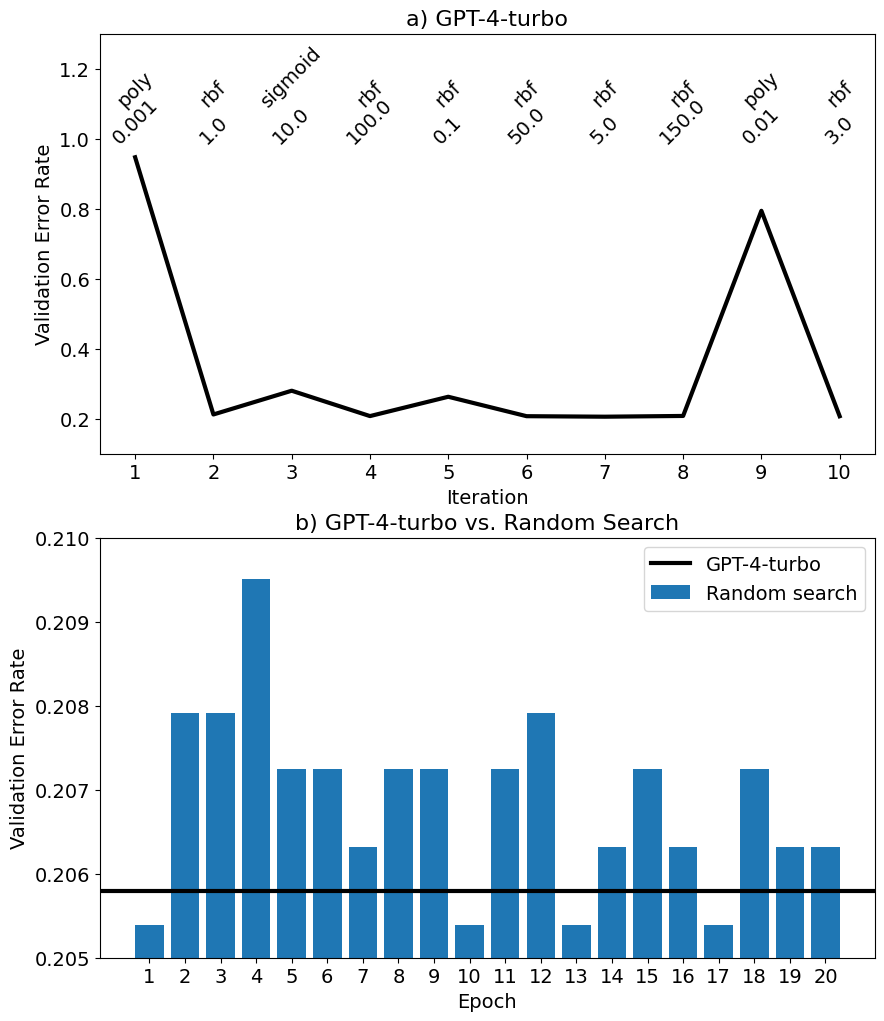

In [15]:
logdir = "./Hyperparametertuning/data/"
log_llm = logdir + "svc_losses_llm_search_s100_it10.json"
log_randomsearch = logdir + "svc_losses_random_search_s100_it10_epoch20.json"
fout="/Users/pwag/OneDrive - PPI AG/Dokumente/Artikel/Hyperparameter tuning with LLMs/Bilder/figure3.png"

plot_losses(log_randomsearch, log_llm, ylim1 = [0.1,1.3], ylim2 = [0.205,0.21], print_param=True, fout=fout)


## XGBoost

### Use LLM for hyperparamter tuning

In [4]:
classifier = "xgboost"
n_iter = 20
#fout = f"./Hyperparametertuning/data/{classifier}_losses_llm_search_s100_it{n_iter}.json"
fout = "./Hyperparametertuning/data/test.json"

LLM_Tuner = LLM_Hyperparamter_tuner(classifier=classifier, train=train, test=test)
LLM_Tuner.run_optimization(iterations=n_iter, fout=fout)

### Random search

In [10]:
parameter_grid = {
    'n_estimators': [int(i) for i in np.arange(50,1000,100)],
    'max_leaves': [int(i) for i in np.arange(1,500,10)],
    'min_child_weight': [int(i) for i in np.arange(0,10,1)],
    'learning_rate': [float(i) for i in np.logspace(-4, -1, 4)],
    'subsample': [float(i) for i in np.arange(0,1,0.1)],
    'colsample_bylevel': [float(i) for i in np.arange(0,1,0.1)],
    'colsample_bytree': [float(i) for i in np.arange(0,1,0.1)],
    'reg_alpha': [0,0.1,0.5,1,5,10],
    'reg_lambda': [0,0.1,0.5,1,5,10]
    }

classifier = "xgboost"
n_epochs = 20
n_iter = 10
fout = f"./Hyperparametertuning/data/{classifier}_losses_random_search_s100_it{n_iter}_epoch{n_epochs}.json"

RS_Tuner = RandomSearch_Tuner(classifier_type=classifier, train_data=train, test_data=test)
RS_Tuner.tune(parameter_grid, n_iter, n_epochs, fout)


Epoch 0
New best loss: 0.32899628252788105
Config: {'subsample': 0.6000000000000001, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 750, 'min_child_weight': 6, 'max_leaves': 231, 'learning_rate': 0.0001, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.2}
-------------
New best loss: 0.3194370685077005
Config: {'subsample': 0.8, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 450, 'min_child_weight': 3, 'max_leaves': 461, 'learning_rate': 0.0001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5}
-------------
New best loss: 0.27947424322889003
Config: {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 450, 'min_child_weight': 1, 'max_leaves': 101, 'learning_rate': 0.001, 'colsample_bytree': 0.1, 'colsample_bylevel': 0.6000000000000001}
-------------
New best loss: 0.24375995751460433
Config: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 750, 'min_child_weight': 7, 'max_leaves': 41, 'learning_rate': 0.1, 'colsample_bytree': 0.600

[{'epoch': 0,
  'iteration': 0,
  'config': {'subsample': 0.6000000000000001,
   'reg_lambda': 1,
   'reg_alpha': 5,
   'n_estimators': 750,
   'min_child_weight': 6,
   'max_leaves': 231,
   'learning_rate': 0.0001,
   'colsample_bytree': 0.9,
   'colsample_bylevel': 0.2},
  'loss': 0.32899628252788105},
 {'epoch': 0,
  'iteration': 1,
  'config': {'subsample': 0.1,
   'reg_lambda': 1,
   'reg_alpha': 0.5,
   'n_estimators': 950,
   'min_child_weight': 7,
   'max_leaves': 261,
   'learning_rate': 0.001,
   'colsample_bytree': 0.5,
   'colsample_bylevel': 0.5},
  'loss': 0.3405469994689325},
 {'epoch': 0,
  'iteration': 2,
  'config': {'subsample': 0.8,
   'reg_lambda': 5,
   'reg_alpha': 0,
   'n_estimators': 450,
   'min_child_weight': 3,
   'max_leaves': 461,
   'learning_rate': 0.0001,
   'colsample_bytree': 0.6000000000000001,
   'colsample_bylevel': 0.5},
  'loss': 0.3194370685077005},
 {'epoch': 0,
  'iteration': 3,
  'config': {'subsample': 0.5,
   'reg_lambda': 1,
   'reg_alph

### Auto ML

In [7]:
automl = AutoML()
automl_settings = {
    "time_budget": 900,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": f"./Hyperparametertuning/data/automl_s100_t900.log",
    "estimator_list": ['xgboost'],
}

automl.fit(
    X_train=train['embedding'], y_train=train['target'],
    X_val=test['embedding'], y_val=test['target'],
    **automl_settings)

[flaml.automl.logger: 01-04 19:24:29] {1679} INFO - task = classification
[flaml.automl.logger: 01-04 19:24:29] {1687} INFO - Data split method: stratified
[flaml.automl.logger: 01-04 19:24:29] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-04 19:24:29] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 01-04 19:24:29] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-04 19:24:29] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-04 19:24:29] {2344} INFO - Estimated sufficient time budget=6170s. Estimated necessary time budget=6s.
[flaml.automl.logger: 01-04 19:24:29] {2391} INFO -  at 0.6s,	estimator xgboost's best error=0.4574,	best estimator xgboost's best error=0.4574
[flaml.automl.logger: 01-04 19:24:29] {2218} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-04 19:24:30] {2391} INFO -  at 1.2s,	estimator xgboost's best error=0.4574,	best estimator xgboost's be

## Plot results

LLM beats Random Search: 10 / 20
AutoML beats Random Search: 9 / 20


/var/folders/dg/8n0xxn4d09b0l8s58qy23x5snx2m3q/T/ipykernel_9116/753751527.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(np.arange(1, len(loss_llm)+1), size=14)
/var/folders/dg/8n0xxn4d09b0l8s58qy23x5snx2m3q/T/ipykernel_9116/753751527.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(np.arange(1, len(loss_rs)+1), size=14)


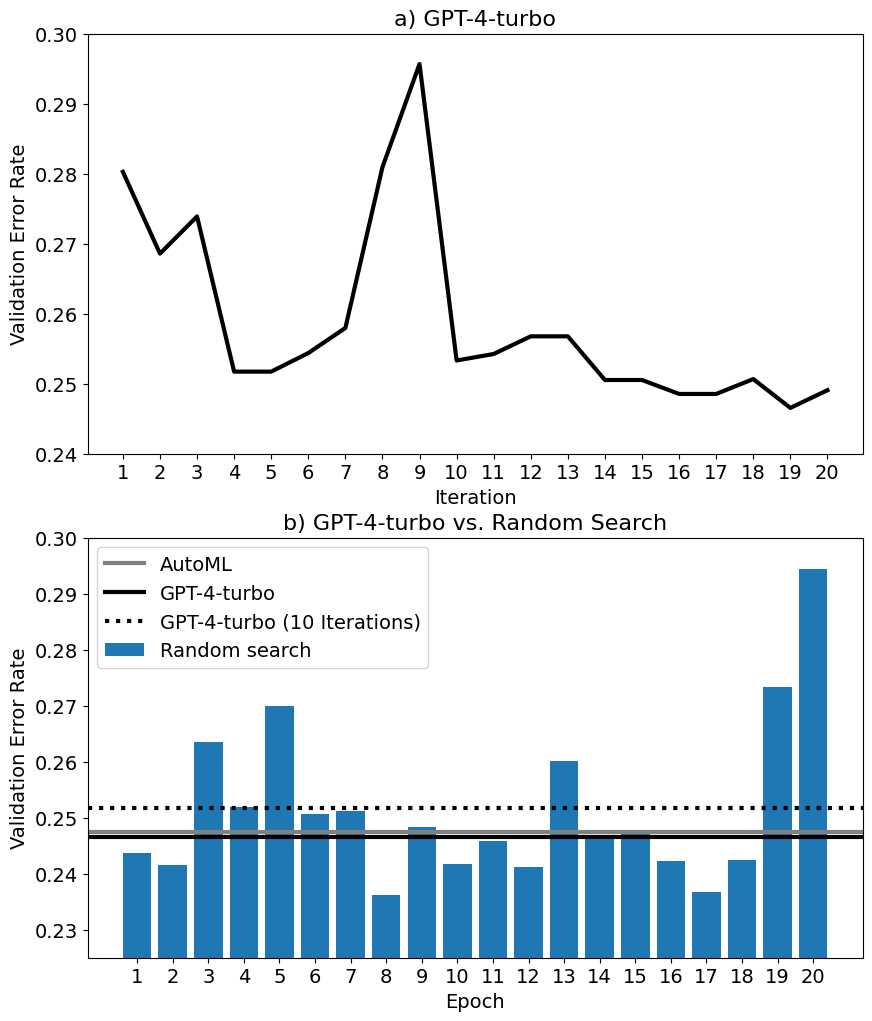

In [14]:

logdir = "./Hyperparametertuning/data/"

log_llm = logdir + "xgboost_losses_llm_search_s100_it20.json"
log_randomsearch = logdir + "xgboost_losses_random_search_s100_it10_epoch20.json"
log_automl = logdir + "xgboost_automl_s100_t900.log"
fout="/Users/pwag/OneDrive - PPI AG/Dokumente/Artikel/Hyperparameter tuning with LLMs/Bilder/figure4.png"

plot_losses(log_randomsearch, log_llm,ylim1=[0.24,0.3], ylim2 = [0.225,0.3], file_automl=log_automl, fout=fout)